In [39]:
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
## Plotly
import re
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
# Others
import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import nltk
import json
from sklearn.feature_extraction.text import CountVectorizer
import time
from nltk.stem.wordnet import WordNetLemmatizer
from contextlib import contextmanager
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.metrics import roc_curve, auc
# Create a function to calculate the error metrics, since we'll be doing this several times
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
# Create a function to calculate the error metrics, since we'll be doing this several times
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
    
    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
        
    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    return cm_results

In [11]:
data = pd.read_csv('short_data.csv')

In [17]:
text = data.comment_text
# Text preprocessing steps - remove numbers, captial letters and punctuation
alphabetic = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
# text
text = text.map(alphabetic).map(punc_lower)
text.head()  

0    this is a great story  man  i wonder if the pe...
1    yet call out all muslims for the acts of a few...
2    because the people who drive cars more are the...
3    mormons have had a complicated relationship wi...
4                         i m doing the same thing    
Name: comment_text, dtype: object

In [18]:
data['text'] = text
x = data['text']
data['target'] = np.where(data['target']>=0.5,1,0)
y = data['target']

In [19]:
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
data = pad_sequences(sequences, maxlen=50)

In [21]:
model = Sequential()
model.add(Embedding(20000, 100, input_length=50))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
model.fit(data, np.array(y), validation_split=0.4, epochs=3)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 141052 samples, validate on 94035 samples
Epoch 1/3
141052/141052 [==============================] - 150s 1ms/step - loss: 0.2419 - accuracy: 0.9135 - val_loss: 0.2338 - val_accuracy: 0.9124
Epoch 2/3
 67040/141052 [=============>................] - ETA: 1:08 - loss: 0.1922 - accuracy: 0.9260

KeyboardInterrupt: 

In [28]:
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [29]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocabulary_size, 100))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [35]:
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
data = pad_sequences(sequences, maxlen=50)

In [36]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.25, random_state=42)

In [37]:
model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, 100, input_length=50, weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(0.2))
model_glove.add(Conv1D(64, 5, activation='relu'))
model_glove.add(MaxPooling1D(pool_size=4))
model_glove.add(LSTM(100))
model_glove.add(Dense(1, activation='sigmoid'))
model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
model_glove.fit(x_train, y_train, epochs = 3)

Epoch 1/3
176315/176315 [==============================] - 44s 247us/step - loss: 0.2817 - accuracy: 0.8980
Epoch 2/3
176315/176315 [==============================] - 43s 243us/step - loss: 0.2601 - accuracy: 0.9044
Epoch 3/3
176315/176315 [==============================] - 43s 244us/step - loss: 0.2531 - accuracy: 0.9064


In [41]:
y_pred = model_glove.predict(x_test)

In [44]:
y_pred = np.where(y_pred >= 0.5, 1, 0)

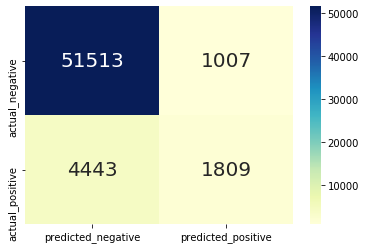

In [45]:
cm = conf_matrix(y_test, y_pred)

In [46]:
# Compile all of the error metrics into a dataframe for comparison
results = pd.DataFrame(list(zip(cm)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['CNN']
results

,CNN
Accuracy,0.907
Precision,0.642
Recall,0.289
F1 Score,0.399


In [49]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.25, random_state=42, stratify=y)

In [51]:
x_balance, y_balance = RandomOverSampler().fit_sample(x_train, y_train)

In [52]:
model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, 100, input_length=50, weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(0.2))
model_glove.add(Conv1D(64, 5, activation='relu'))
model_glove.add(MaxPooling1D(pool_size=4))
model_glove.add(LSTM(100))
model_glove.add(Dense(1, activation='sigmoid'))
model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [53]:
model_glove.fit(x_balance, y_balance, epochs = 3)

Epoch 1/3
314918/314918 [==============================] - 77s 244us/step - loss: 0.5026 - accuracy: 0.7546
Epoch 2/3
314918/314918 [==============================] - 76s 242us/step - loss: 0.4379 - accuracy: 0.7944
Epoch 3/3
314918/314918 [==============================] - 76s 242us/step - loss: 0.3988 - accuracy: 0.8175


In [54]:
y_pred = model_glove.predict(x_test)

In [55]:
y_pred = np.where(y_pred >= 0.5, 1, 0)

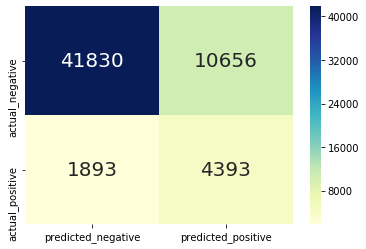

In [56]:
cm = conf_matrix(y_test, y_pred)

In [57]:
# Compile all of the error metrics into a dataframe for comparison
results = pd.DataFrame(list(zip(cm)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['CNN']
results

,CNN
Accuracy,0.786
Precision,0.292
Recall,0.699
F1 Score,0.412
